In [1]:
# -*- coding: utf-8 -*-
# -*- authors : Vincent Roduit -*-
# -*- date : 2025-04-24 -*-
# -*- Last revision: 2025-05-02 by janzgraggen -*-
# -*- python version : 3.10.4 -*-
# -*- Description: Notebook that summarizes the main results-*-

# <center> EE-452: Network Machine Learning </center>
## <center> Ecole Polytechnique Fédérale de Lausanne </center>
### <center>Graph-based EEG Analysis </center>
---

In [48]:
#import libraries
import pandas as pd
from pathlib import Path
from torch_geometric.utils import to_networkx
from seiz_eeg.dataset import EEGDataset
import matplotlib.pyplot as plt
import mne

#import modules
from transform_func import *
from utils import *
from dataloader import *


%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Load data and compute statistics

In [38]:
data_path = "../data"

DATA_ROOT = Path(data_path)

clips_train = pd.read_parquet(DATA_ROOT / "train/segments.parquet")
clips_test = pd.read_parquet(DATA_ROOT / "test/segments.parquet")

# You can change the signal_transform, or remove it completely
data_train = EEGDataset(
    clips_train,
    signals_root=DATA_ROOT / "train",
    signal_transform=None,
    prefetch=True,  # If your compute does not allow it, you can use `prefetch=False`
)

data_test = EEGDataset(
    clips_test,
    signals_root=DATA_ROOT / "test",
    signal_transform=None,
    prefetch=True,  # If your compute does not allow it, you can use `prefetch=False`
)

## Data Distribution

In [40]:
clips_train
# Count how often the label is 0 and 1 in clips_train
label_counts = clips_train['label'].value_counts()
label_proportions = clips_train['label'].value_counts(normalize=True)

print(f"There are {len(clips_train)} training clips in total.")
print(f"There are {label_counts[0]} clips with label 0 and {label_counts[1]} clips with label 1.")
print(f"The proportion of label 0 is {label_proportions[0]:.2f} and label 1 is {label_proportions[1]:.2f}.")

There are 12993 training clips in total.
There are 10476 clips with label 0 and 2517 clips with label 1.
The proportion of label 0 is 0.81 and label 1 is 0.19.


## Data Summary

In [41]:
def get_summary_stats(df):
    df = df.reset_index()
    sessions_per_patient = df.groupby('patient')['session'].nunique()
    segments_per_session = df.groupby(['patient', 'session']).size()
    return {
        'Number of patients': df['patient'].nunique(),
        'sessions_per_patient': {
            'mean': sessions_per_patient.mean(),
            'median': sessions_per_patient.median(),
            'min': sessions_per_patient.min(),
            'max': sessions_per_patient.max()
        },
        'segments_per_session': {
            'mean': segments_per_session.mean(),
            'median': segments_per_session.median(),
            'min': segments_per_session.min(),
            'max': segments_per_session.max()
        }
    }

train_stats = get_summary_stats(clips_train)
test_stats = get_summary_stats(clips_test)

# Build the multi-index table
arrays = [
    ['Train', 'Train', 'Test', 'Test'],
    [train_stats['Number of patients'], train_stats['Number of patients'],
     test_stats['Number of patients'], test_stats['Number of patients']],
    ['sessions_per_patient', 'segments_per_session', 'sessions_per_patient', 'segments_per_session']
]
index = pd.MultiIndex.from_arrays(arrays, names=['Set', 'Number of patients', 'Statistic'])

data = [
    [train_stats['sessions_per_patient']['mean'], train_stats['sessions_per_patient']['median'],
     train_stats['sessions_per_patient']['min'], train_stats['sessions_per_patient']['max']],
    [train_stats['segments_per_session']['mean'], train_stats['segments_per_session']['median'],
     train_stats['segments_per_session']['min'], train_stats['segments_per_session']['max']],
    [test_stats['sessions_per_patient']['mean'], test_stats['sessions_per_patient']['median'],
     test_stats['sessions_per_patient']['min'], test_stats['sessions_per_patient']['max']],
    [test_stats['segments_per_session']['mean'], test_stats['segments_per_session']['median'],
     test_stats['segments_per_session']['min'], test_stats['segments_per_session']['max']],
]

summary = pd.DataFrame(data, index=index, columns=['Mean', 'Median', 'Min', 'Max'])

# Output as LaTeX table
print(summary.to_latex(float_format="%.2f"))

\begin{tabular}{lllrrrr}
\toprule
 &  &  & Mean & Median & Min & Max \\
Set & Number of patients & Statistic &  &  &  &  \\
\midrule
\multirow[t]{2}{*}{Train} & \multirow[t]{2}{*}{97} & sessions_per_patient & 1.82 & 1.00 & 1 & 7 \\
 &  & segments_per_session & 73.41 & 62.00 & 1 & 285 \\
\cline{1-7} \cline{2-7}
\multirow[t]{2}{*}{Test} & \multirow[t]{2}{*}{25} & sessions_per_patient & 2.00 & 1.00 & 1 & 7 \\
 &  & segments_per_session & 72.28 & 54.00 & 3 & 470 \\
\cline{1-7} \cline{2-7}
\bottomrule
\end{tabular}



# Adjency Matrix


In [34]:
path = os.getcwd()
cfg_corr = read_yml(os.path.join(path ,'../config/exp/gcn/gcn_corr_fft.yml')).get("config_dataset")
cfg_coherence = read_yml(os.path.join(path ,'../config/exp/gcn/gcn_coherence_band_energies.yml')).get("config_dataset")
cfg_distance = read_yml(os.path.join(path, '../config/exp/gcn/gcn_dist_fft.yml')).get("config_dataset")
cfg_distance['graph']['path'] = '../data/distances_3d.csv'

In [ ]:
#when testing use subset
first_1000_segments = [data_train[i] for i in range(1000)]
graph_distance, distance_adj_mat  = graph_construction(data_train,cfg_distance.get("graph", None), cfg_distance)
graph_corr, corr_adj_mat = graph_construction(data_train,cfg_corr.get("graph", None), cfg_corr)
graph_coherence, coherence_adj_matrix = graph_construction(data_train,cfg_coherence.get("graph", None), cfg_coherence)

/opt/homebrew/Caskroom/miniconda/base/envs/nml-project/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:1858: RuntimeWarning: invalid value encountered in divide
  Cxy = np.abs(Pxy)**2 / Pxx / Pyy


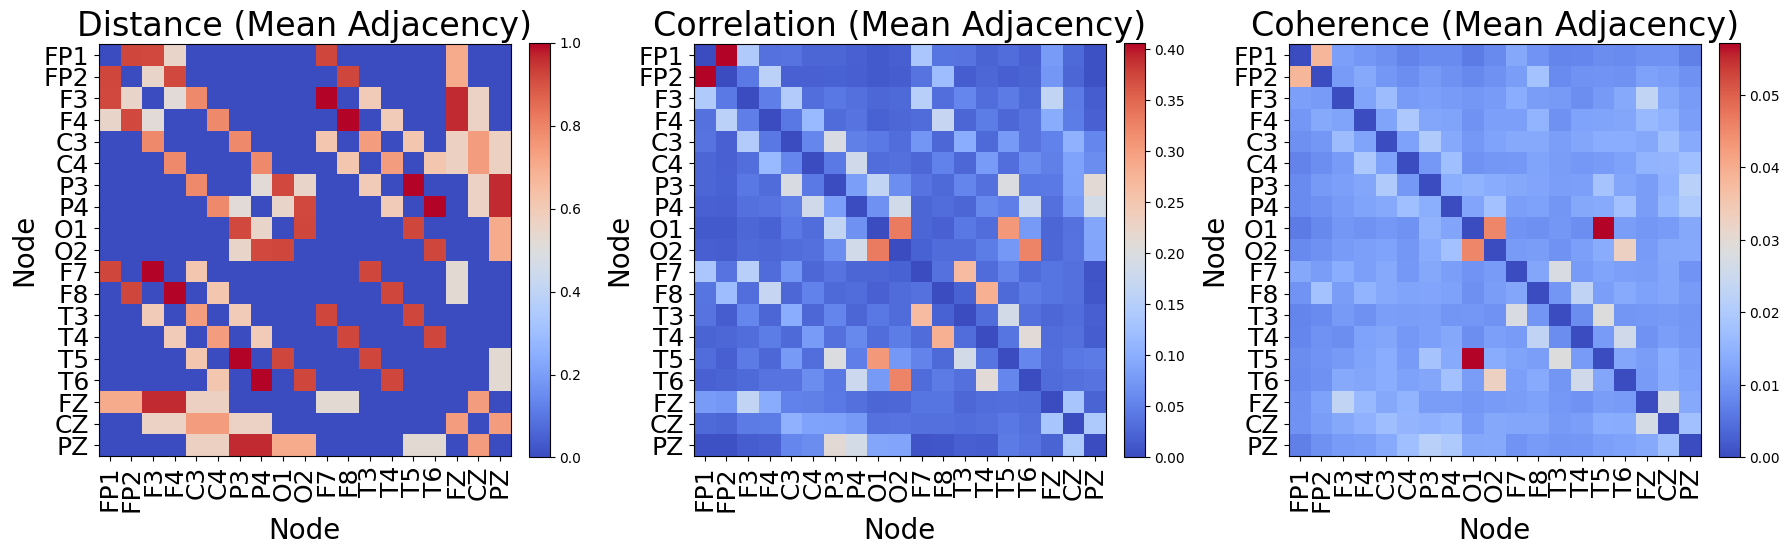

In [42]:
distance_df = pd.read_csv(os.path.join(data_path, 'distances_3d.csv'))

# Get unique node names for axis ticks
node_names = distance_df['from'].unique()

# Calculate mean adjacency matrices
num_nodes = 19

mean_adj_coherence = np.stack(coherence_adj_matrix).mean(axis=0)
mean_adj_distance = distance_adj_mat
mean_adj_corr = np.stack(corr_adj_mat).mean(axis=0)

# Plot the three heatmaps side by side with node names as ticks
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

# 1. Distance
im0 = axs[0].imshow(mean_adj_distance, cmap='coolwarm', interpolation='nearest')
axs[0].set_title('Distance (Mean Adjacency)', fontsize=24)
axs[0].set_xticks(np.arange(num_nodes))
axs[0].set_yticks(np.arange(num_nodes))
axs[0].set_xticklabels(node_names, rotation=90, fontsize=18)
axs[0].set_yticklabels(node_names, fontsize=18)
plt.colorbar(im0, ax=axs[0], fraction=0.046, pad=0.04)

# 2. Correlation
im1 = axs[1].imshow(mean_adj_corr, cmap='coolwarm', interpolation='nearest')
axs[1].set_title('Correlation (Mean Adjacency)', fontsize=24)
axs[1].set_xticks(np.arange(num_nodes))
axs[1].set_yticks(np.arange(num_nodes))
axs[1].set_xticklabels(node_names, rotation=90, fontsize=18)
axs[1].set_yticklabels(node_names, fontsize=18)
plt.colorbar(im1, ax=axs[1], fraction=0.046, pad=0.04)

# 3. Coherence
im2 = axs[2].imshow(mean_adj_coherence, cmap='coolwarm', interpolation='nearest')
axs[2].set_title('Coherence (Mean Adjacency)', fontsize=24)
axs[2].set_xticks(np.arange(num_nodes))
axs[2].set_yticks(np.arange(num_nodes))
axs[2].set_xticklabels(node_names, rotation=90, fontsize=18)
axs[2].set_yticklabels(node_names, fontsize=18)
plt.colorbar(im2, ax=axs[2], fraction=0.046, pad=0.04)

for ax in axs:
    ax.set_xlabel('Node', fontsize=20)
    ax.set_ylabel('Node', fontsize=20)

plt.tight_layout()
plt.show()

fig.savefig("heat_map_adjacency_matrices.png")


# Visualize Signals

In [44]:
def create_mne_signal(eeg, sfreq, ch_names):
    eeg = eeg * 1e-6
    # Create MNE Info object
    info = mne.create_info(ch_names=ch_names, sfreq=sfreq, ch_types=['eeg'] * len(ch_names))
    # Create Raw object
    raw = mne.io.RawArray(eeg, info, verbose=False)
    # Set montage
    montage = mne.channels.make_standard_montage('standard_1020')
    raw.set_montage(montage, verbose=False)
    return raw

def plot_eeg_sensors(eeg, sfreq, ch_names, title='EEG Topomap'):
    raw = create_mne_signal(eeg, sfreq, ch_names)
    
    # Plot sensors and get the figure
    fig = mne.viz.plot_sensors(raw.info, kind='topomap', show_names=True, show=True)
    
    # Add title to the actual figure
    fig.suptitle(title, fontsize=14)
    
    return fig

def plot_signal(eeg, sfreq, ch_names):
    n_channels = eeg.shape[0]
    raw = create_mne_signal(eeg, sfreq, ch_names=ch_names)
    raw.plot(n_channels=n_channels,duration=12, show_scrollbars=False, title='EEG Recording with 10-20 Montage');

def plot_topo(eeg, sfreq, ch_names):
    raw = create_mne_signal(eeg, sfreq, ch_names)
    spectrum = raw.compute_psd()
    fig = spectrum.plot_topomap()

    return fig
# Plot the EEG signal

In [46]:
labels = data_train.get_label_array()

#get idx of class 0
idx_class_0 = np.where(labels == 0)[0]
idx_class_1 = np.where(labels == 1)[0]

eeg_0 = data_train[idx_class_0[1]][0].T
eeg_1 = data_train[idx_class_1[1]][0].T

In [49]:
ch_names = [
        'Fp1', 'Fp2', 'F7', 'F3', 'Fz', 'F4', 'F8',
        'T7', 'C3', 'Cz', 'C4', 'T8',
        'P7', 'P3', 'Pz', 'P4', 'P8',
        'O1', 'O2'
    ]

raw0 = create_mne_signal(eeg_0, 250, ch_names=ch_names)
raw1 = create_mne_signal(eeg_1, 250, ch_names=ch_names)

Plotting power spectral density (dB=True).
Plotting power spectral density (dB=True).


/opt/homebrew/Caskroom/miniconda/base/envs/nml-project/lib/python3.10/site-packages/mne/viz/utils.py:158: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)
/opt/homebrew/Caskroom/miniconda/base/envs/nml-project/lib/python3.10/site-packages/mne/viz/utils.py:158: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


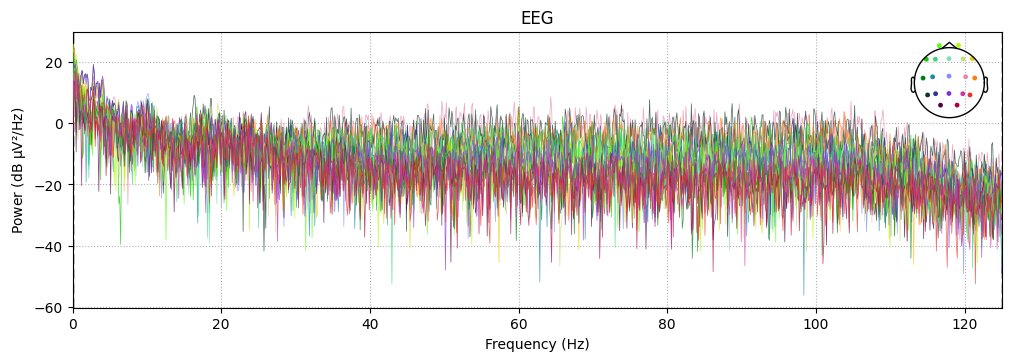

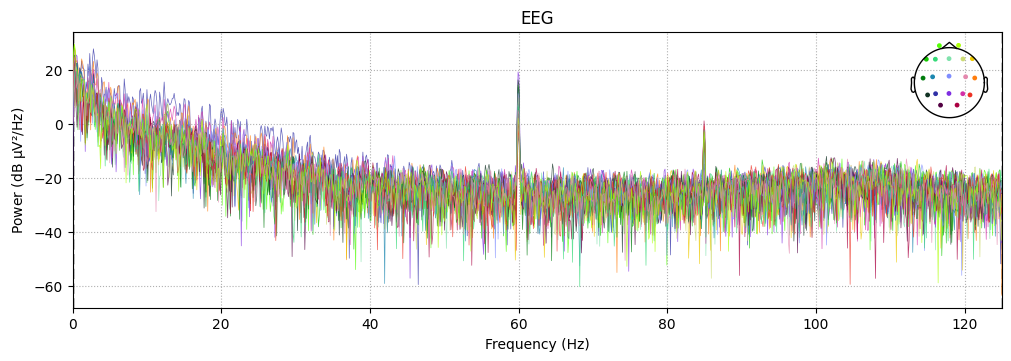

In [50]:
fig = raw0.compute_psd(verbose=False).plot();
fig.savefig("psd_class_0.png")
fig = raw1.compute_psd(verbose=False).plot();
fig.savefig("psd_class_1.png")

Effective window size : 8.192 (s)
Plotting power spectral density (dB=True).


/opt/homebrew/Caskroom/miniconda/base/envs/nml-project/lib/python3.10/site-packages/mne/viz/utils.py:158: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


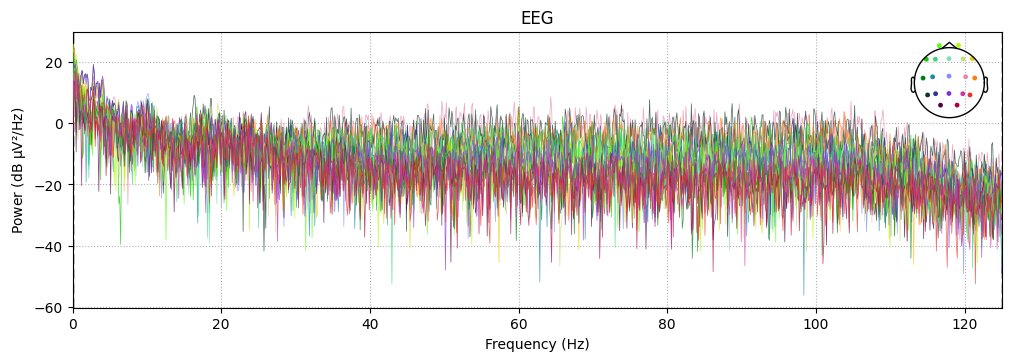

In [51]:
raw0.compute_psd().plot();

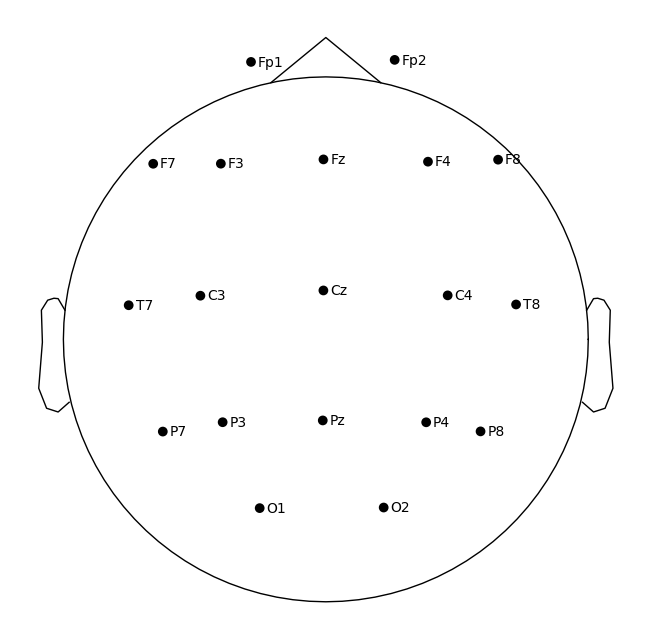

In [52]:
sfreq = 250  # Sampling frequency in Hz
plot_eeg_sensors(eeg_0, sfreq, ch_names=ch_names);

Using matplotlib as 2D backend.


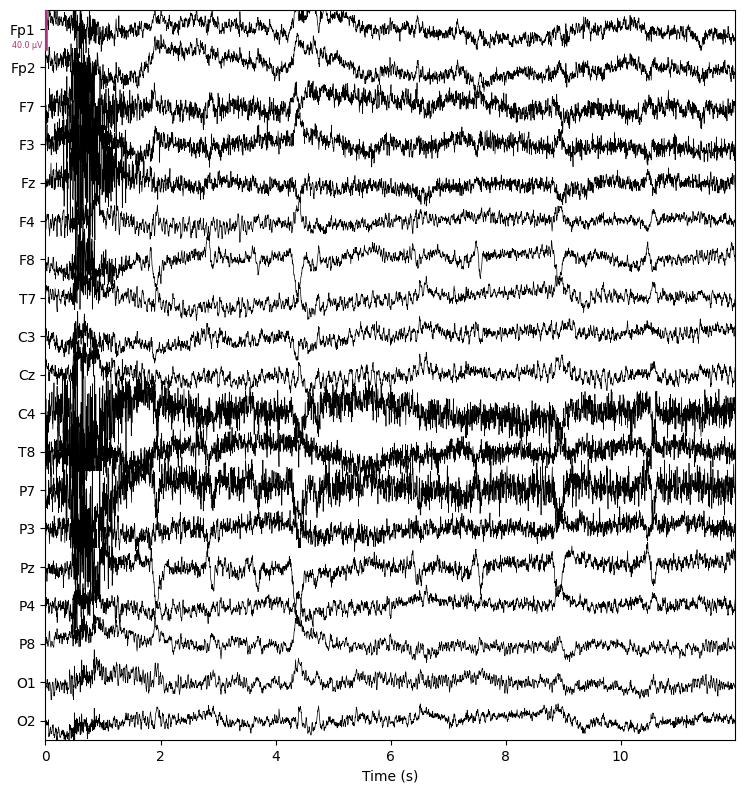

Effective window size : 8.192 (s)


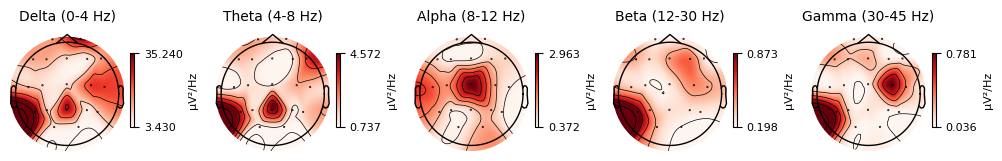

In [53]:
plot_signal(eeg_0, sfreq, ch_names=ch_names);

plot_topo(eeg_0, sfreq, ch_names=ch_names);

Effective window size : 8.192 (s)


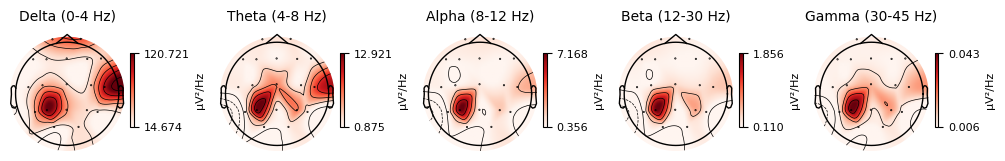

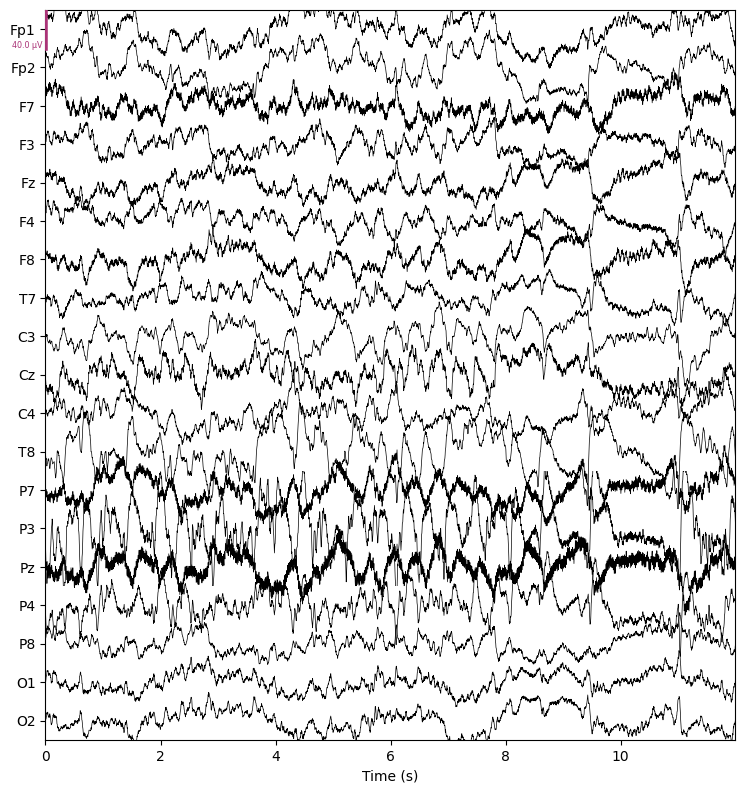

In [54]:
plot_topo(eeg_1, sfreq, ch_names=ch_names);

plot_signal(eeg_1, sfreq, ch_names=ch_names);


# Plot learning curve